In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
plt.style.use('tableau-colorblind10')
plt.rcParams.update({'font.size': 15})

In [2]:
NI, NJ, NK = 400, 800, 10
LENLON, LENLAT, MAXIMUM_DEPTH = 500., 1000., 2000.
WESTLON, SOUTHLAT = 0.0, 0.0

In [3]:
ANGSTROM = 10e-10
H_TO_M = 1.0  # A constant that translates the model's internal
              # units of thickness into m.
M_TO_H = 1./H_TO_M

### Coordinate grid
X = np.linspace(WESTLON+LENLON/NI, LENLON, NI)
Y = np.linspace(SOUTHLAT+LENLAT/NJ, LENLAT, NJ)
Z = [k for k in range(NK)]
Xm, Ym = np.meshgrid(X,Y)

def flat_bottom():
    D = MAXIMUM_DEPTH*np.ones((NI,NJ))
    return D

def const_velocity(u0,v0):
    u = u0*np.ones((NI,NJ,NK))
    v = v0*np.ones((NI,NJ,NK))
    return u,v

# This is a function that is needed in the initialize_thickness routine. It returns a one-dimensional (z)
# array with interface positions.
def get_eta0(HalfStrat):
    # Returns a 1-d array lisiting the nominal positions of the interfaces
    eta0 = np.zeros(NK+1)
    
    half_depth = MAXIMUM_DEPTH*HalfStrat
    eta0[0] = 0.0 # Surface
    eta0[NK] = -MAXIMUM_DEPTH # Bottom
    for k in range(1, NK//2):
        eta0[k] = -half_depth*(2.0*k/NK)
    for k in range(NK//2, NK):
        eta0[k] = -MAXIMUM_DEPTH - 2.0*(MAXIMUM_DEPTH-half_depth)*((k-NK)/float(NK))
    
    return eta0


# Returns an array h[i,j,k] representing the layer thickness of the
# k-th layer at point (X[i],Y[j]) and an array eta[i,j,k] with the heights of each interface.
# Note that h has NK values in the vertical while eta has NK+1 values.
# k=0 is the surface layer, with increasing k descending down the layers.
# h[i,j,k] >= ANGSTROM, which is the minimum layer thickness.
# input : D[i,j], a two-dimensional array of the depth of the ocean.
def initialize_thickness(D,HalfStrat):
    
    eta0 = np.zeros(NK+1) # The 1-d nominal positions of the interfaces.
    eta_im = np.zeros((NJ,NK+1)) # A temporary array for zonal-mean eta, m.
    eta1D = np.zeros(NK+1) # Interface height relative to the sea surface
                           # positive upward, in m.
    eta = np.zeros((NI,NJ,NK+1))
    h = np.zeros((NI,NJ,NK)) # h[:,:,k] is the thickness of layer k
                             # k=0 is the uppermost layer.
    
    # This sets up eta0, which seems to be the depth of the interface.
    # eta0[0] is the surface of the ocean, eta0[NK] is the bottom.
    half_depth = MAXIMUM_DEPTH*HalfStrat
    
    eta0 = get_eta0(HalfStrat)
    
    # Now we set up et_im
    # First set top and bottom layers in eta_im
    eta_im[:,0] = 0.0
    eta_im[:,NK] = -MAXIMUM_DEPTH
    # Set the rest of eta_im, ensuring that the interface heights
    # do not go above the ocean surface or below the bottom boundary.
    # This is done by letting the interfaces take the value of the 
    # boundaries.
    for j in range(NJ):
        for k in range(1,NK):
            y_2 = Y[j] - SOUTHLAT - 0.5*LENLAT
            eta_im[j,k] = eta0[k] 
            if (eta_im[j,k] > 0.0): eta_im[j,k] = 0.0
            if (eta_im[j,k] < -MAXIMUM_DEPTH): eta_im[j,k] = -MAXIMUM_DEPTH
    
    ##
    for i in range(NI):
        for j in range(NJ):
            eta[i,j,NK] = -D[i,j]
            eta1D[NK] = -D[i,j]
            for k in range(NK-1,-1,-1):
                eta[i,j,k] = eta_im[j,k]
                # Ensure that layers are atleast one ANGSTROM apart.
                if (eta[i,j,k] < (eta[i,j,k+1] + ANGSTROM)):
                    
                    eta[i,j,k] = eta[i,j,k+1] + ANGSTROM
                    h[i,j,k] = ANGSTROM
                else:
                    h[i,j,k] = M_TO_H * (eta[i,j,k] - eta[i,j,k+1])
                    # h is the layer thickness in the internal
                    # units of thickness.
 
    return h, eta

def initialize_thickness_user(D,eta0):
    
    eta_im = np.zeros((NJ,NK+1)) # A temporary array for zonal-mean eta, m.
    eta = np.zeros((NI,NJ,NK+1))
    h = np.zeros((NI,NJ,NK)) # h[:,:,k] is the thickness of layer k
                             # k=0 is the uppermost layer.
    
    
    # Now we set up et_im
    # First set top and bottom layers in eta_im
    # Set the rest of eta_im, ensuring that the interface heights
    # do not go above the ocean surface or below the bottom boundary.
    # This is done by letting the interfaces take the value of the 
    # boundaries.
    for j in range(NJ):
        for k in range(0,NK+1):
            eta_im[j,k] = eta0[k] 
            if (eta_im[j,k] > 0.0): eta_im[j,k] = 0.0
            if (eta_im[j,k] < -MAXIMUM_DEPTH): eta_im[j,k] = -MAXIMUM_DEPTH
    ##
    for i in range(NI):
        for j in range(NJ):
            eta[i,j,NK] = -D[i,j]
            for k in range(NK-1,-1,-1):
                eta[i,j,k] = eta_im[j,k]
                # Ensure that layers are atleast one ANGSTROM apart.
                if (eta[i,j,k] < (eta[i,j,k+1] + ANGSTROM)):
                    
                    eta[i,j,k] = eta[i,j,k+1] + ANGSTROM
                    h[i,j,k] = ANGSTROM
                else:
                    h[i,j,k] = M_TO_H * (eta[i,j,k] - eta[i,j,k+1])
                    # h is the layer thickness in the internal
                    # units of thickness.
 
    return h, eta


def step(X,Y, shelf_width, shelf_depth):
    D = np.zeros((NI,NJ))
    for i in range(NI):
        for j in range(NJ):
            if Y[j] < shelf_width:
                D[i,j] = shelf_depth
            else:
                D[i,j] = MAXIMUM_DEPTH
    return D

def slope(X,Y,shelf_width, min_shelf_depth,max_shelf_depth, steepness):
    D = np.zeros((NI,NJ))
    steepness = steepness*1e3
    slope_width = (MAXIMUM_DEPTH-max_shelf_depth)/steepness
    print("Slope width = {}".format(slope_width))
    shelf_steepness = (max_shelf_depth-min_shelf_depth)/shelf_width
    for i in range(NI):
        for j in range(NJ):
            if Y[j] < shelf_width:
                D[i,j] = min_shelf_depth + shelf_steepness*Y[j]
            elif Y[j] < shelf_width + slope_width:
                D[i,j] = max_shelf_depth + steepness*(Y[j]-shelf_width)
            else:
                D[i,j] = MAXIMUM_DEPTH
    return D

def slope_tanh(X,Y,L_shelf,Hs, L_slope, At=0, Lt=0):
    #Hs = 400.
    Hd = MAXIMUM_DEPTH
    #L_slope = 200
    #L_shelf = 100
    Ws = 0.5*(L_slope)
    #Ys = (L_shelf + 0.5*L_slope)
    
    D = np.zeros((NI,NJ))
    for i in range(NI):
        x = X[i]
        Ys = (L_shelf + At*np.sin(2*np.pi*x/Lt))  + 0.5*L_slope
        for j in range(NJ):
            y = Y[j]
            D[i,j] = (Hs + 0.5*(Hd-Hs)*( 1 + np.tanh((y-Ys)/Ws) ))
    return D

def slope_tanh_gauss(X,Y,shelf_width,Hs, slope_width,At,sd):
    Hd = MAXIMUM_DEPTH
    L_slope = slope_width
    L_shelf = shelf_width
    Ws = 0.5*(L_slope)
    #Ys = (L_shelf + 0.5*L_slope)
    
    D = np.zeros((NI,NJ))
    for i in range(NI):
        x = X[i]
        Ys = (L_shelf + At*np.exp(-(x-LENLON/2.)**2/(2*sd**2)))  + 0.5*L_slope
        for j in range(NJ):
            y = Y[j]
            D[i,j] = (Hs + 0.5*(Hd-Hs)*( 1 + np.tanh((y-Ys)/Ws) ))
    return D

def slope_tanh_trough(X,Y,L_shelf,Hs, L_slope,x0,trough_width,trough_depth,r=0.1):
    Hd = MAXIMUM_DEPTH
    Ws = 0.5*(L_slope)
    
    Ys = L_shelf  + 0.5*L_slope
    x1 = x0+trough_width

    D = np.zeros((NI,NJ))   
    H = np.zeros(NI)
    for i in range(NI):
        x = X[i]
        H[i] = Hs + trough_depth*double_exp(x,x0,x1,r)

        for j in range(NJ):
            y = Y[j]
            D[i,j] = H[i] + 0.5*(Hd-H[i])*( 1 + np.tanh((y-Ys)/Ws) )
    return D

def slope_tanh_trough_gauss(X,Y,L_shelf,Hs, L_slope,x0,trough_width,trough_depth,Wt,At=0, sd=0, trough_depth2=0):
    Hd = MAXIMUM_DEPTH
    Ws = 0.5*(L_slope)
    
    Ys = L_shelf  + 0.5*L_slope
    x1 = x0+trough_width
    xc = (x0+x1)/2.

    D = np.zeros((NI,NJ))   
    H = np.zeros(NI)
    for i in range(NI):
        x = X[i]
        H[i] = Hs + trough_depth*box_tanh(x,x0,x1,Wt) + trough_depth2*box_tanh(x,x0,x1,Wt)
        Ys = (L_shelf + At*np.exp(-(x-xc)**2/(2*sd**2)))  + 0.5*L_slope
        for j in range(NJ):
            y = Y[j]
            D[i,j] = H[i] + 0.5*(Hd-H[i])*( 1 + np.tanh((y-Ys)/Ws) )
    return D

def slope_tanh_land(X,Y,H_shelf, L_slope, L_shelf, x0=0, t_width=0, t_depth=0, At=0, sd=1, Al= 0, L_land=0, L_land_wv=1):
    H_deep = MAXIMUM_DEPTH
    W_slope = 0.5*L_slope
    yc_shelf = L_shelf + W_slope
    
    x1 = x0 + t_width
    xc = 0.5*(x0+x1)
    
    D = np.zeros((NI,NJ))
    H = np.zeros(NI)
    for i in range(NI):
        x = X[i]
        
        H[i] = H_shelf + t_depth*box_tanh(x,x0,x1,W_slope) 
        Ys = (yc_shelf + At*np.exp(-(x-xc)**2/(2*sd**2)))  
        for j in range(NJ):
            y = Y[j] - L_land - Al*np.sin(2*np.pi*x/L_land_wv)
            if (y < 0):
                D[i,j] = -1
            else:
                D[i,j] = H[i] + 0.5*(H_deep - H[i])*(( 1 + np.tanh((y-Ys)/W_slope)))
    return D


def wind_stress_exp(X,Y,tau0, Ld_atmos):    
    wind = np.zeros((NI,NJ))
    
    for i in range(NI):
        x = X[i]
        for j in range(NJ):
            y = Y[j]
            wind[i,j] = tau0*np.exp(-y/Ld_atmos)
    
    return wind


def wind_stress_sin(X,Y,tau0,y1,y2,p):
    
    Xwind = np.zeros((NI,NJ))
    Ywind = np.zeros((NI,NJ))
    
    for i in range(NI):
        x = X[i]
        for j in range(NJ):
            y = Y[j]
            if (y1 < y) and (y < y2):
                y0 = y - y1
                arg = np.pi*(y0)/(y2-y1)
                Xwind[i,j] = tau0*np.abs(np.sin(arg))**p
    return Xwind

def wind_stress_double_sin2(X,Y):
    tau_acc = 0.0
    tau_asf = -0.025
    
    Y_shelf = 150
    Y_slope = 150
    
    Xwind = np.zeros((NI,NJ))
    Ywind = np.zeros((NI,NJ))
    
    for i in range(NI):
        x = X[i]
        for j in range(NJ):
            y = Y[j]
            if (Y_shelf < y) and (y < Y_shelf+Y_slope):
                arg = np.pi*(Y_shelf+Y_slope-y)/Y_slope
                Xwind[i,j] = tau_asf*np.sin(arg)**2
            if Y_shelf+Y_slope < y:
                arg = np.pi*(y-Y_shelf-Y_slope)/(LENLAT-Y_shelf-Y_slope)
                Xwind[i,j] = tau_acc*np.sin(arg)**2
    
    return Xwind, Ywind

def wind_stress_double_exp(X,Y,tau0,y1,y2,Ld,r):
    Xwind = np.zeros((NI,NJ))
    
    A1 = np.exp(r*y1)
    A2 = np.exp(r*y2)
    for i in range(NI):
        for j in range(NJ):
            y = Y[j]
            R = np.exp(r*y)
            Xwind[i,j] = ( (A1+R)**(-1.) - (A2+R)**(-1.) )*tau0*R*np.exp(-(y-y1)/Ld)
    return Xwind

def double_exp(y,y1,y2,r):    
    A1 = np.exp(r*y1)
    A2 = np.exp(r*y2)
    R = np.exp(r*y)
    return  ( (A1+R)**(-1.) - (A2+R)**(-1.) )*R

def box_tanh(y,y1,y2,W):    
    tanh1 = np.tanh((y-y1)/W)
    tanh2 = np.tanh((y-y2)/W)
    return  0.5*(tanh1 - tanh2)
                
def add_wind_pert(Xwind):
    ## Takes in a 2D velocity array and adds a small perturbation
    ## with amplitude VelocityPerturbAmp
    
    amp = 0.00001
    for i in range(NI):
        for j in range (NJ):
            y_2 = (Y[j] - SOUTHLAT - 0.5*LENLAT) / LENLAT
            x_2 = (X[i] - WESTLON - 0.5*LENLON) / LENLON

            Xwind[i,j] += amp*\
                    (0.1*np.abs(np.cos(10.*np.pi*x_2)) -\
                     np.abs(np.sin(5.*np.pi*y_2)) )
            for m in range(1,11):
                Xwind[i,j] += 0.1*amp*\
                    np.cos(2.0*m*np.pi*x_2+2*m)*np.cos(6.0*np.pi*y_2)
    return Xwind

def tracer_shelf(X,Y):
    Y_shelf = 50
    
    tr = np.zeros((NI,NJ))
    for i in range(NI):
        x = X[i]
        for j in range(NJ):
            y= Y[j]
            if (y<Y_shelf):
                tr[i,j] = 1.
    
    return tr


def sponge_Idamp(X,Y,sponge_width,Idamp_val):    
    Idamp = np.zeros((NI,NJ))
    for i in range(NI):
        for j in range(NJ):
            y = Y[j]
            Idamp[i,j] = Idamp_val*np.exp(-(y-LENLAT)**2/(2*sponge_width**2))
    return Idamp

## Larger values of surf will provide make layers more concenrtated near the surface
def exp_strat(NK,surf):
    first = -1*surf
    last = 0
    
    if first>last:
        first,last = last,first
        
    exp_first = np.exp(first)
    exp_last = np.exp(last)
    step = (exp_last-exp_first)/(NK-1)
    
    out = np.zeros(NK)
    A = np.linspace(exp_first, exp_last, NK)
    for i in range(len(A)):
        a = A[i]
        out[i] = np.log(a)
    return MAXIMUM_DEPTH*(1/surf)*np.asarray([a for a in reversed(out)])


In [4]:
# shelf_width = 150
#min_shelf_depth = 400
#max_shelf_depth = 500
#steepness = 0.03
#Depth = slope(X,Y,shelf_width, min_shelf_depth, max_shelf_depth, steepness)

Hs = 400
shelf_width = 200
land_width = 0
slope_width = 100
shelf_slope_width = 200
x0 = 2000


trough_width = 500
trough_depth = 1000
Wt = 120
At = 0
Al = 0
L_land = 0
L_land_wv = 1
#Depth,H = slope_tanh_trough(X,Y,shelf_width,Hs, slope_width,x0,trough_width,trough_depth)
#Depth = slope_tanh(X,Y,shelf_width,Hs, slope_width, At=100, Lt=1000)
#Depth = slope_tanh_trough_gauss(X,Y,shelf_width,Hs, slope_width,x0,trough_width,trough_depth,Wt,At=750,sd=trough_width/8.)

Depth = slope_tanh_land(X,Y,Hs, slope_width, shelf_width, x0=x0, \
                        t_width=trough_width, t_depth=trough_depth, At=At, sd=trough_width/8.,\
                        Al=Al, L_land=L_land, L_land_wv=L_land_wv)


#Depth = slope_tanh_land(X,Y,Hs, slope_width, shelf_width)

#eta0 = [0,-200,-500,-1000,-MAXIMUM_DEPTH]
surf = 4
eta0 = exp_strat(NK+1,surf)


#eta0 = [0,-MAXIMUM_DEPTH]
h, eta = initialize_thickness_user(Depth,eta0)

#Ld_atmos = 750
tau0 = +0.05
y1 = -100
y2 = Y[-1]-25
#stress_x = wind_stress_exp(X,Y,tau0,Ld_atmos)
#stress_x = wind_stress_sin(X,Y,tau0,y1,y2,2)
Ld = 750
r = 0.1
stress_x = wind_stress_double_exp(X,Y,tau0,y1,y2,Ld,r)
stress_y = np.zeros(stress_x.shape) 
stress_x  = add_wind_pert(stress_x)


sponge_width = 50
Idamp_val = 1/(8*7*24*3600)
Idamp = sponge_Idamp(X,Y,sponge_width,Idamp_val)

u, v = const_velocity(0.,0.)


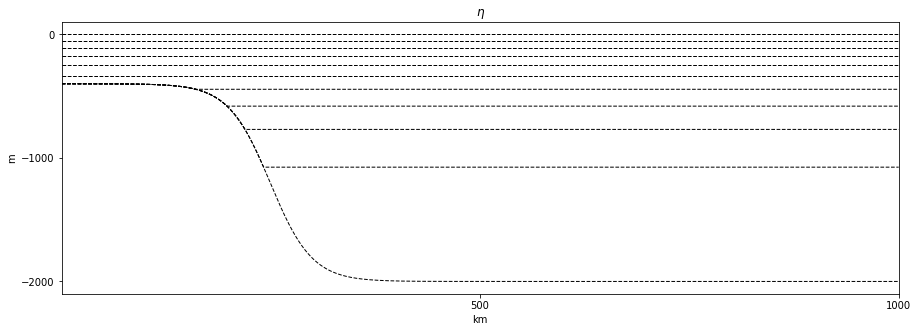

In [5]:
#slope_width= (MAXIMUM_DEPTH-max_shelf_depth)/(1e3*steepness)


fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)

for k in range(NK+1):
    ax.plot(Y,eta[0,:,k], color='k', linestyle='--', linewidth=1.0)
#ax.plot(Y,-Depth[0,:], color='k', linewidth=1.5)
    
ax.set_title(r'$\eta$')
ax.set_xlim([Y[0],Y[-1]])
ax.set_ylabel('m')
ax.set_xlabel('km')

#ax.axvline(x=shelf_width, linestyle='--',color='k')
#ax.axvline(x=shelf_width+slope_width, linestyle='--',color='k')

plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)

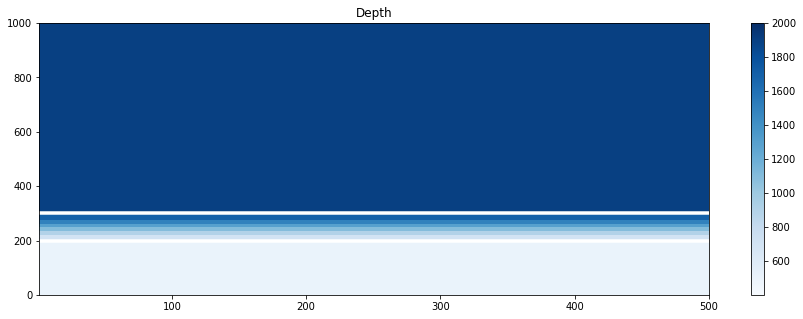

In [6]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(111)
ax.set_title(r'Depth')
im = ax.contourf(Xm,Ym,Depth.T, cmap='Blues')
m = plt.cm.ScalarMappable(cmap='Blues')
m.set_array(Depth.T)
plt.colorbar(m)

ax.axhline(y=shelf_width, linestyle='-',color='w', linewidth=3.5)
ax.axhline(y=shelf_width+slope_width, linestyle='-',color='w', linewidth=3.5)

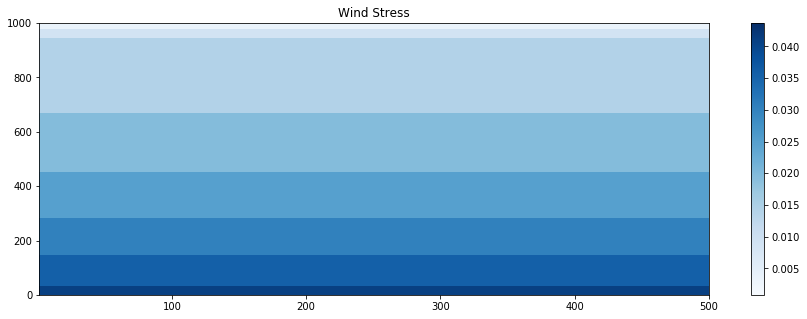

In [7]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(111)
ax.set_title(r'Wind Stress')
im = ax.contourf(Xm,Ym,stress_x.T, cmap='Blues')
m = plt.cm.ScalarMappable(cmap='Blues')
m.set_array(stress_x.T)
plt.colorbar(m)

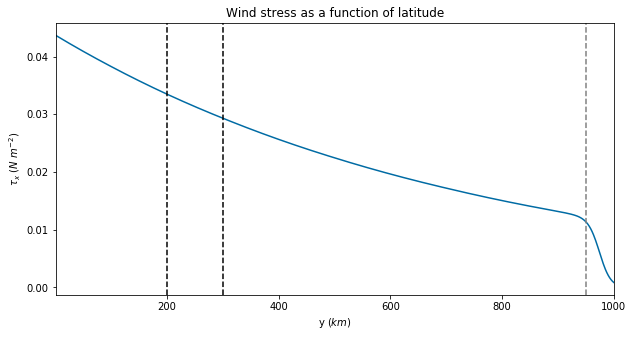

In [8]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(Y,stress_x[0,:])
ax.set_xlim([Y[0],Y[-1]])
ax.set_xlabel('y $(km)$')
ax.set_ylabel(r'$\tau_x$ $(N\ m^{-2})$')
ax.set_title(r'Wind stress as a function of latitude')

ax.axvline(x=shelf_width,color='k',linestyle='--')
ax.axvline(x=shelf_width+slope_width,color='k',linestyle='--')

ax.axvline(x=Y[-1]-sponge_width,color='0.5',linestyle='--')

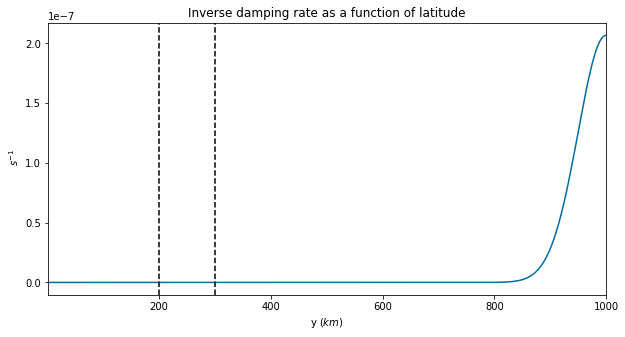

In [9]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(Y,Idamp[0,:])
ax.set_xlim([Y[0],Y[-1]])
ax.set_xlabel('y $(km)$')
ax.set_ylabel(r' $s^{-1}$')
ax.set_title(r'Inverse damping rate as a function of latitude')

ax.axvline(x=shelf_width,color='k',linestyle='--')
ax.axvline(x=shelf_width+slope_width,color='k',linestyle='--')

In [10]:
f = 1.26302877E-4 
g = 9.8
#gint = 5e-3
gint = 0.0196
gint = 0.00196
H = MAXIMUM_DEPTH
h_arr = h[-1,-1,:]
hmin = min(h_arr)
hmax = max(h_arr)
               
external = np.sqrt(g*H)/f
internal = np.sqrt(gint*hmin)/f

print("External deformation radius {0:2E}km".format(external/1e3))
print("Internal deformation radius {0:2F}km".format(internal/1e3))
print("Gridsize {}km".format(LENLAT/NJ))
print("Timestep {}s".format((LENLAT/NJ)*1e3/(np.sqrt(gint*hmax))))

External deformation radius 1.108447E+03km
Internal deformation radius 2.519462km
Gridsize 1.25km
Timestep 928.3488299183632s


In [11]:
InputFile = nc.Dataset("input.nc","w",format="NETCDF3_64BIT_OFFSET")

f_nx = InputFile.createDimension("nx",NI)
f_ny = InputFile.createDimension("ny",NJ)
f_nz = InputFile.createDimension("nz",NK)
f_nz1 = InputFile.createDimension("nz+1",NK+1)


f_nx = InputFile.createVariable("nx","f8",("nx"))
f_nx[:]=X
f_nx.standard_name = "x location at cell centers"
f_nx.units = "km"

f_ny = InputFile.createVariable("ny","f8",("ny"))
f_ny[:]=Y
f_ny.standard_name = "y location at cell center"
f_ny.units = "km"

f_nz = InputFile.createVariable("nz","f8",("nz"))
f_nz[:] = Z

f_nz1 = InputFile.createVariable("nz+1","f8",("nz+1"))
f_nz1[:] = [i for i in range(NK+1)]

f_u = InputFile.createVariable("u","f8", ("nz","ny","nx"))
f_u[:,:,:] = u.T
f_u.standard_name = "zonal velocity"
f_u.units = "m s^-1"

f_v = InputFile.createVariable("v", "f8", ("nz","ny","nx"))
f_v[:,:,:] = v.T
f_v.standard_name = "meridional velocity"
f_v.units = "m s^-1"

f_h = InputFile.createVariable("h", "f8", ("nz","ny","nx"))
f_h[:,:,:] = h.T
f_h.standard_name = "layer thickness"
f_h.units = "m"

f_eta = InputFile.createVariable("eta", "f8", ("nz+1","ny","nx"))
f_eta[:,:,:] = eta.T
f_eta.standard_name = "interface height"
f_eta.units = "m"

f_depth = InputFile.createVariable("depth","f8",("ny","nx"))
f_depth[:,:]= Depth.T
f_depth.standard_name = "topographic depth at cell centers"
f_depth.units = "m"

f_stress_x = InputFile.createVariable("STRESS_X", "f8", ("ny","nx"))
f_stress_x[:,:] = stress_x.T
f_stress_x.standard_name = "zonal wind stress"
f_stress_x.units = "N m^-2"

f_stress_y = InputFile.createVariable("STRESS_Y", "f8", ("ny","nx"))
f_stress_y[:,:] = stress_y.T
f_stress_y.standard_name = "meridional wind stress"
f_stress_y.units = "N m^-2"

f_Idamp = InputFile.createVariable("IDAMP", "f8", ("ny","nx"))
f_Idamp[:,:] = Idamp.T
f_Idamp.standard_name = "Inverse damping "
f_Idamp.units = "s-1"

f_ETA = InputFile.createVariable("ETA", "f8", ("nz+1","ny","nx"))
f_ETA[:,:,:] = eta.T
f_ETA.standard_name = "interface height to sponge towards"
f_ETA.units = "m"

InputFile.close()

In [12]:
print(2*np.pi/LENLON)
print(2*np.pi/(3600*11))

0.012566370614359173
0.00015866629563584815


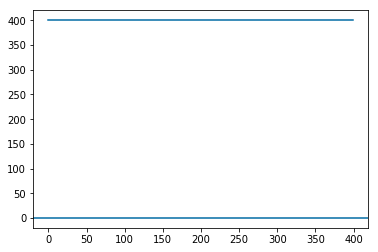

In [13]:
plt.plot(Depth[:,30])
plt.axhline(y=0)

In [14]:
print(np.max(-Depth[:,:]))

-400.07636056978953


In [15]:
def exp_strat(NK):
    first = -1
    last = 0
    
    if first>last:
        first,last = last,first
        
    exp_first = np.exp(first)
    exp_last = np.exp(last)
    step = (exp_last-exp_first)/(NK-1)
    
    out = np.zeros(NK)
    A = np.linspace(exp_first, exp_last, NK)
    for i in range(len(A)):
        a = A[i]
        out[i] = np.log(a)
    return MAXIMUM_DEPTH*np.asarray([a for a in reversed(exp_list(NK))])

eta0 = MAXIMUM_DEPTH*np.asarray([a for a in reversed(exp_list(NK))])

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for eta in eta0:
    ax.axhline(eta)
ax.set_ylim([-MAXIMUM_DEPTH,50])


NameError: name 'exp_list' is not defined

In [ ]:
eta0

In [ ]:
gint = 0.00196 
h = 32
N2 = gint/h
N2

In [ ]:
h0 = [-eta0[i]+ eta0[i-1] for i in range(1,len(eta0))]
h0